<div style="font-family:Baskerville; border-style: solid;border-color:#254E58; border-width:2px; border-radius:5px; padding:10px;margin: 1px; text-align:left; width:47%; float:right; background-color:HoneyDew ">
If you enjoyed my notebook and found it useful, <span style="color:white; background-color:Crimson">please consider upvoting it</span>❤️. 
<u>Your support means a lot and helps to spread the word to others who may also benefit from this information.</u><b> Thank you for your time!</b>

<div style="font-family:Helvetica; font-size:14px; line-height: 1.4">
 <strong>Update:</strong> Added new features:
    <ul >
        <li>Advanced Vocabulary</li>
        <li>Number of <b>repetitions</b> in the text</li>
    </ul>
</div>
<div style="font-family:Helvetica; font-size:22px; line-height: 1.4">
For a comprehensive exploration of this features, you can refer to the complete EDA notebook <a href="https://www.kaggle.com/code/vassylkorzh/commonlit-eda-of-generated-features">here</a>,
and for the Visual Data Storytelling notebook <a href="https://www.kaggle.com/code/vassylkorzh/data-story-what-make-the-summary-great">here</a>.

<div style="letter-spacing:1px">
    <h1 style='padding: 20px;
              color:black;
              text-align:center;
              font-weight:bold'>
        Import Libraries
    </h1>
</div>

In [14]:
import pandas as pd
from tqdm import tqdm
from IPython.display import display, Markdown
import os

In [15]:
pd.set_option('display.max_columns', None)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
tqdm.pandas()

<div style="letter-spacing:1px">
    <h1 style='padding: 20px;
              color:black;
              text-align:center;
              font-weight:bold'>
        Custom Functions
    </h1>
</div>

In [16]:
def __display(s):
    '''
    The function for displaying the output as markdown
    '''
    display(Markdown(s))

<div style="letter-spacing:1px">
    <h1 style='padding: 20px;
              color:black;
              text-align:center;
              font-weight:bold'>
        Load Data
    </h1>
</div>

In [17]:
summaries_train = pd.read_csv('summaries_train.csv')
prompt_train = pd.read_csv('prompts_train.csv')
__display(f"**Summaries** train shape: {summaries_train.shape}")
display(summaries_train.head())
__display(f"**Prompt** train shape: {prompt_train.shape}")
display(prompt_train.head())

**Summaries** train shape: (7165, 5)

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording  
0  0.205683  0.380538  
1 -0.548304  0.506755  
2  3.128928  4.231226  
3 -0.210614 -0.471415  
4  3.272894  3.219757

**Prompt** train shape: (4, 4)

prompt_id                                    prompt_question  \
0    39c16e  Summarize at least 3 elements of an ideal trag...   
1    3b9047  In complete sentences, summarize the structure...   
2    814d6b  Summarize how the Third Wave developed over su...   
3    ebad26  Summarize the various ways the factory would u...   

                prompt_title  \
0                 On Tragedy   
1  Egyptian Social Structure   
2             The Third Wave   
3    Excerpt from The Jungle   

                                         prompt_text  
0  Chapter 13 \r\nAs the sequel to what has alrea...  
1  Egyptian society was structured like a pyramid...  
2  Background \r\nThe Third Wave experiment took ...  
3  With one member trimming beef in a cannery, an...

* create joined dataframe

In [18]:
full_data = pd.merge(summaries_train, prompt_train, on='prompt_id')
full_data.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   
2  0095993991fe    814d6b  The third wave only started as an experiment w...   
3  00c20c6ddd23    814d6b  The experimen was orginally about how even whe...   
4  00d40ad10dc9    814d6b  The third wave developed so quickly due to the...   

    content   wording                                    prompt_question  \
0  0.205683  0.380538  Summarize how the Third Wave developed over su...   
1  3.272894  3.219757  Summarize how the Third Wave developed over su...   
2  0.205683  0.380538  Summarize how the Third Wave developed over su...   
3  0.567975  0.969062  Summarize how the Third Wave developed over su...   
4 -0.910596 -0.081769  Summarize how the Third Wave developed over su...   

     prompt_title                                        prompt_text  
0  The Third Wave  Background \r\nThe Third Wave experiment took ...  
1  The Third Wave  Background \r\nThe Third Wave experiment took ...  
2  The Third Wave  Background \r\nThe Third Wave experiment took ...  
3  The Third Wave  Background \r\nThe Third Wave experiment took ...  
4  The Third Wave  Background \r\nThe Third Wave experiment took ...

<div style="letter-spacing:1px">
    <h1 style='padding: 20px;
              color:black;
              text-align:center;
              font-weight:bold'>
        Feature Engineering
    </h1>
</div>

## Text Length

In [33]:
from transformers import AutoTokenizer

Instantiate one of the tokenizer classes of the library from a pre-trained model vocabulary.

The **model_name** could be modified, here is the list of the available tokenizers: https://huggingface.co/docs/transformers/v4.31.0/en/model_doc/auto#transformers.AutoTokenizer

In [34]:
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [35]:
def count_text_length(df, col, tokenizer=tokenizer):
    return df[col].progress_apply(lambda x: len(tokenizer.encode(x)))

In [39]:
#  to not repeat the same process for each prompt in a record
# let's create temporary df with the prompt_id and prompt_length info 
tmp_prompt_length_df = full_data.groupby('prompt_id').prompt_text.first().transform(lambda x: len(tokenizer.encode(x))).reset_index().rename(columns={'prompt_text': 'prompt_length'})
full_data = pd.merge(full_data, tmp_prompt_length_df, on='prompt_id')
tmp_prompt_length_df

prompt_id  prompt_length
0    39c16e            767
1    3b9047            659
2    814d6b            673
3    ebad26           1175

In [40]:
full_data['summary_length'] = count_text_length(full_data, 'text')
full_data.head(2)

100%|██████████| 7165/7165 [00:01<00:00, 5364.80it/s]


student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording                                    prompt_question  \
0  0.205683  0.380538  Summarize how the Third Wave developed over su...   
1  3.272894  3.219757  Summarize how the Third Wave developed over su...   

     prompt_title                                        prompt_text  \
0  The Third Wave  Background \r\nThe Third Wave experiment took ...   
1  The Third Wave  Background \r\nThe Third Wave experiment took ...   

   quotes_count  ERR_MISSPELL  prompt_length_x  prompt_length_y  \
0             0             2              673              673   
1             4            10              673              673   

   summary_length  prompt_length  
0              71            673  
1             263            673

## POS tagging

In [71]:
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# Sample text
text = "The quick brown fox jumps over the lazy dog."

# Tokenize the text into words
tokens = word_tokenize(text)

# Remove punctuations
tokens_without_punctuations = [word for word in tokens if word not in string.punctuation]

# Perform POS tagging
pos_tags = pos_tag(tokens_without_punctuations)

# Print the POS tags
# print(pos_tags)

pos_counts = Counter(tag for word, tag in pos_tags)

In [81]:
pos_tag(['did','not'])

[('did', 'VBD'), ('not', 'RB')]

In [82]:
def count_pos_tags(text):
    tokens = word_tokenize(text)
    tokens_without_punctuations = [word for word in tokens if word not in string.punctuation]
    pos_tags = pos_tag(tokens_without_punctuations)
    pos_counts = nltk.FreqDist(tag for word, tag in pos_tags)
    return pos_counts

df1 = full_data.copy()

pos_counts_df = df1['text'].progress_apply(count_pos_tags).apply(pd.Series)

pos_counts_df = pos_counts_df.fillna(0)

# include only these tags
pos_included_tags = ['DT', 'JJ', 'NN', 'VBD', 'VB', 'WRB', 'NNS', 'TO', 'CD', 'PRP', 'IN',
       'VBP', 'WDT', 'VBZ', 'CC', 'VBG', 'JJR', 'RB', 'NNP', 'JJS', 'VBN',
       'EX', 'MD', 'PRP$', 'POS', 'WP', 'RBR', ':']

pos_counts_df = pos_counts_df.filter(items=pos_included_tags).reindex(columns=pos_included_tags, fill_value=0)

# Concatenate the new DataFrame with the original one
result_df = pd.concat([df1, pos_counts_df], axis=1)


100%|██████████| 7165/7165 [00:15<00:00, 477.25it/s]


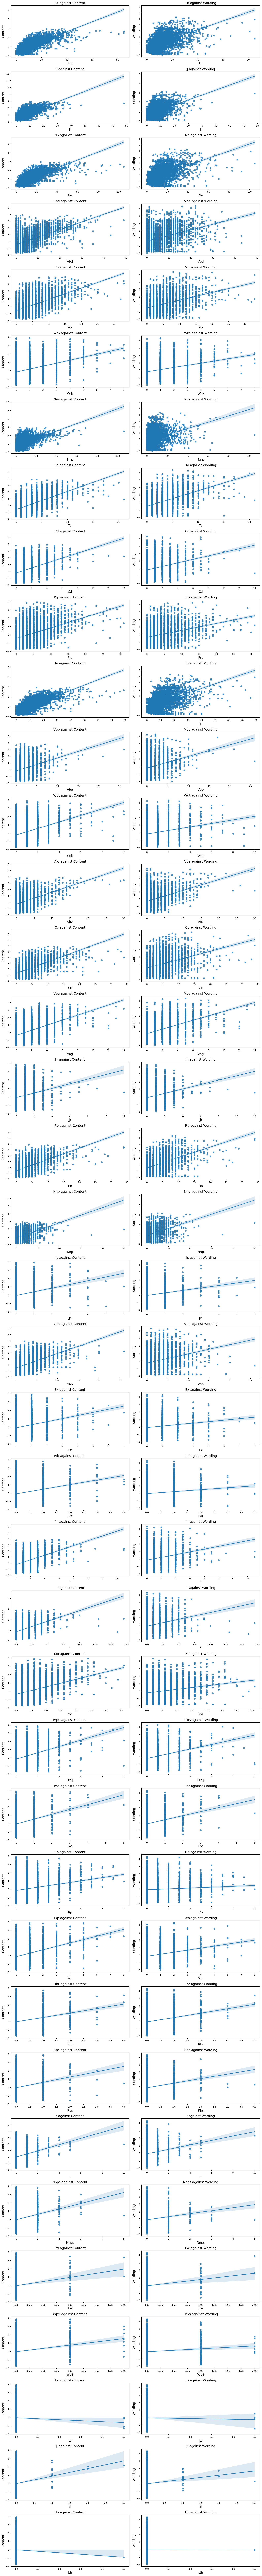

In [87]:
import matplotlib.pyplot as plt

def plot_distribution(df, target):
    num_rows = len(df.columns)
    num_cols = len(target.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 4*num_rows))

    for i, col_name in enumerate(df.columns):
        for j, target_name in enumerate(target.columns):
            ax = axes[i, j]
            sns.regplot(x=df[col_name], y=target[target_name], ax=ax)

            ax.set_title(f'{col_name.title()} against {target_name.title()}', fontsize=14)
            ax.set_xlabel(col_name.title(), fontsize=14)
            ax.set_ylabel(target_name.title(), fontsize=14)

    plt.tight_layout()
    plt.show()
    
plot_distribution(pos_counts_df, full_data[['content','wording']])

In [ ]:
full_data['text'].apply(pos_tagging)

## Length Ratio

In [41]:
full_data['length_ratio'] = full_data['summary_length'] / full_data['prompt_length']

## Word Overlap

In [21]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

STOP_WORDS = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jadonng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jadonng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [43]:
STOP_WORDS = set(stopwords.words('english'))

def word_overlap_ratio(row, stop_words=STOP_WORDS):
    def check_is_stop_word(word):
        return word not in stop_words
    prompt_words = set(word_tokenize(row['prompt_text']))
    summary_words = set(word_tokenize(row['text']))
    
    if stop_words:
        prompt_words = list(filter(check_is_stop_word, prompt_words))
        summary_words = list(filter(check_is_stop_word, summary_words))

    intersection = set(prompt_words).intersection(set(summary_words))
    overlap_ratio = len(intersection)/len(summary_words)
    return overlap_ratio

In [44]:
full_data['word_overlap_ratio'] = full_data.progress_apply(word_overlap_ratio, axis=1)

100%|██████████| 7165/7165 [00:19<00:00, 358.79it/s]


## N-grams Co-occurrence

In [45]:
from nltk import ngrams
from nltk.tokenize import word_tokenize
from collections import Counter

In [46]:
tokenized_prompt = word_tokenize(full_data.loc[0,'prompt_text'])
list(set(ngrams(tokenized_prompt, 2)))[10:20]

[('movement', '“'),
 ('initiate', 'new'),
 ('and', 'loyalty'),
 ('a', 'life'),
 ('class', 'expanded'),
 ('that', 'the'),
 ('up', 'a'),
 ('had', 'over'),
 ('a', 'special'),
 ('strength', ',')]

In [47]:
def ngram_co_occurrence(row, n):
    # Tokenize the original text and summary into words
    original_tokens = word_tokenize(row['prompt_text'])
    summary_tokens = word_tokenize(row['text'])

    # Generate n-grams for the original text and summary
    original_ngrams = set(ngrams(original_tokens, n))
    summary_ngrams = set(ngrams(summary_tokens, n))

    # Calculate the number of common n-grams
    common_ngrams = original_ngrams.intersection(summary_ngrams)

    # # Optionally, you can get the frequency of common n-grams for a more nuanced analysis
    # original_ngram_freq = Counter(ngrams(original_words, n))
    # summary_ngram_freq = Counter(ngrams(summary_words, n))
    # common_ngram_freq = {ngram: min(original_ngram_freq[ngram], summary_ngram_freq[ngram]) for ngram in common_ngrams}

    return len(common_ngrams)

In [48]:
full_data['bigram_overlap_count'] = full_data.progress_apply(ngram_co_occurrence,args=(2,), axis=1 )

100%|██████████| 7165/7165 [00:20<00:00, 355.59it/s]


In [49]:
full_data['trigram_overlap_count'] = full_data.progress_apply(ngram_co_occurrence, args=(3,), axis=1)

100%|██████████| 7165/7165 [00:20<00:00, 354.60it/s]


## NER Overlap

In [33]:
!pip install stanza

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.5/802.5 kB 6.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 6.7 MB/s eta 0:00:00a 0:00:01


In [ ]:
import stanza
import spacy
stanza.download('en')
# spacy.prefer_gpu()

* **Spacy** NER model (More about spaCy NER model: https://spacy.io/usage/linguistic-features#named-entities-101)

In [21]:
spacy_model_name = 'en_core_web_sm'
spacy_ner_model = spacy.load(spacy_model_name,
#                              n_process=-1
                            )

* **Stanza** NER model (More about Stanza: https://stanfordnlp.github.io/stanza/ner.html)

In [22]:
# stanza_ner_model = stanza.Pipeline(lang='en', processors='tokenize,ner')

In [23]:
def ner_overlap_count(row, model=spacy_ner_model):
    def clean_ners(ner_list):
        return set([(ner[0].lower(), ner[1]) for ner in ner_list])
    prompt = model(row['prompt_text'])
    summary = model(row['text'])

    if "spacy" in str(model):
        prompt_ner = set([(token.text, token.label_) for token in prompt.ents])
        summary_ner = set([(token.text, token.label_) for token in summary.ents])
    elif "stanza" in str(model):
        prompt_ner = set([(token.text, token.type) for token in prompt.ents])
        summary_ner = set([(token.text, token.type) for token in summary.ents])
    else:
        raise Exception("Model not supported")

    prompt_ner = clean_ners(prompt_ner)
    summary_ner = clean_ners(summary_ner)

    intersecting_ners = prompt_ner.intersection(summary_ner)

    return dict(Counter([ner[1] for ner in intersecting_ners]))


In [24]:
# Crate dataframe with count of each category NERs overlap for all the summaries
ners_count_df  = full_data.progress_apply(lambda row: pd.Series(ner_overlap_count(row), dtype='float64'), axis=1).fillna(0)

100%|██████████| 7165/7165 [17:00<00:00,  7.02it/s]


In [25]:
ners_count_df['sum'] = ners_count_df.sum(axis=1)
ners_count_df.columns = ['NER_' + col for col in ners_count_df.columns]
display(ners_count_df.head())

NER_CARDINAL  NER_DATE  NER_GPE  NER_LAW  NER_LOC  NER_MONEY  NER_NORP  \
0           1.0       0.0      0.0      0.0      0.0        0.0       0.0   
1           1.0       0.0      0.0      0.0      0.0        0.0       0.0   
2           0.0       0.0      0.0      0.0      0.0        0.0       0.0   
3           0.0       0.0      0.0      0.0      0.0        0.0       0.0   
4           0.0       0.0      0.0      0.0      0.0        0.0       0.0   

   NER_ORDINAL  NER_ORG  NER_PERCENT  NER_PERSON  NER_QUANTITY  NER_TIME  \
0          1.0      0.0          0.0         0.0           0.0       0.0   
1          1.0      0.0          0.0         1.0           0.0       0.0   
2          1.0      0.0          0.0         1.0           0.0       0.0   
3          1.0      0.0          0.0         1.0           0.0       0.0   
4          1.0      0.0          0.0         0.0           0.0       0.0   

   NER_WORK_OF_ART  NER_sum  
0              0.0      2.0  
1              0.0      3.0  
2              0.0      2.0  
3              0.0      2.0  
4              0.0      1.0

In [26]:
# join ner count dataframe with train dataframe
full_data = pd.concat([full_data, ners_count_df], axis=1)

## Number of **Quotes**

In [50]:
import re

In [51]:
def quotes_count(row):
    summary = row['text']
    text = row['prompt_text']
    quotes_from_summary = re.findall(r'"([^"]*)"', summary)
    if len(quotes_from_summary)>0:
        return [quote in text for quote in quotes_from_summary].count(True)
    else:
        return 0

In [52]:
full_data['quotes_count'] = full_data.progress_apply(quotes_count, axis=1)

100%|██████████| 7165/7165 [00:00<00:00, 99174.94it/s]


<AxesSubplot:xlabel='quotes_count', ylabel='Count'>

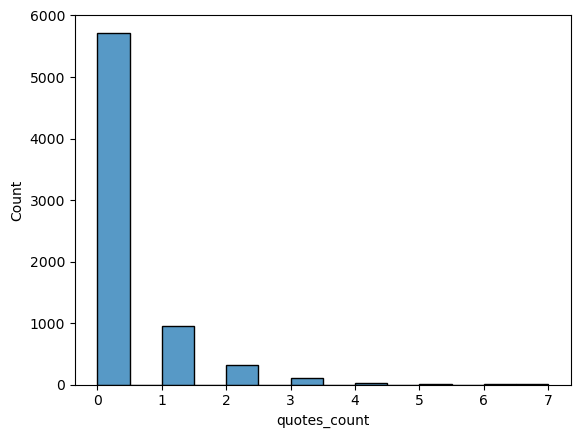

In [53]:
import seaborn as sns
sns.histplot(full_data['quotes_count'])

## Grammar Check

In [16]:
!pip install language-tool-python

In [17]:
import language_tool_python

In [18]:
grammar_check_tool = language_tool_python.LanguageTool('en-US')
def create_grammar_features(row,tool=grammar_check_tool):
    summary = row['text']
    grammar_errors = tool.check(summary)
    unique_mistakes = {}
    for error in grammar_errors:
        if error.ruleIssueType not in unique_mistakes:
            unique_mistakes[error.ruleIssueType] = 1
        else:
            unique_mistakes[error.ruleIssueType] += 1
    return unique_mistakes


CalledProcessError: Command '['/usr/bin/java', '-version']' returned non-zero exit status 1.

In [33]:
mistake_df  = summaries_train.progress_apply(lambda row: pd.Series(create_grammar_features(row), dtype='float64'), axis=1).fillna(0)
display(mistake_df.head())


100%|██████████| 7165/7165 [07:47<00:00, 15.33it/s]


duplication  grammar  inconsistency  misspelling  style  typographical  \
0          0.0      0.0            0.0          3.0    0.0            0.0   
1          0.0      0.0            0.0          1.0    1.0            1.0   
2          0.0      0.0            0.0          1.0    0.0            0.0   
3          0.0      0.0            0.0          1.0    0.0            0.0   
4          0.0      0.0            0.0         14.0    0.0            0.0   

   uncategorized  whitespace  
0            0.0         0.0  
1            0.0         0.0  
2            0.0         1.0  
3            0.0         2.0  
4            0.0         1.0

In [34]:
full_data = pd.concat([full_data, mistake_df], axis=1)

## Misspelling Check
* The idea is taken from this notebook: https://www.kaggle.com/code/friendofsatoshi/spell-checker/notebook


In [54]:
import nltk

In [55]:
!pip install pyspellchecker

In [56]:
from spellchecker import SpellChecker

In [57]:
spell = SpellChecker()

def get_misspell_count(text, spell_checker=spell):
    tokens = nltk.word_tokenize(text)
    mis_tokens = [token for token in spell.unknown(tokens) if token.isalpha()]
    return len(mis_tokens)

In [58]:
full_data['ERR_MISSPELL'] = full_data['text'].apply(
    lambda x: get_misspell_count(x))

## [Semantic Similarity](https://www.sbert.net/examples/applications/semantic-search/README.html?highlight=cosine%20similarity#semantic-search)

Semantic similarity refers to the measure of likeness or **similarity** between two pieces of text **based on their meaning** or context rather than their surface similarity.

The idea behind **semantic similarity** is to capture the **similarity in meaning even if the words used are different**. For example, "dog" and "canine" have high semantic similarity since they both refer to the same concept. On the other hand, "dog" and "table" have low semantic similarity since they represent entirely different concepts.

In [69]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 5.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 MB 9.0 MB/s eta 0:00:0000:0100:01
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125925 sha256=ea6e796f6c7df8679b06ff9bfc1e75760642f0f512b2e4441526a36515b98bdb
  Stored in directory: /Users/jadonng/Library/Caches/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
  Attempting uninstall: to

In [70]:
from sentence_transformers import SentenceTransformer, util
import torch

In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
embeddings_model = SentenceTransformer('sentence-transformers/all-distilroberta-v1', device=device)

* create the dict with prompt_id as key and prompt embedding as value

In [43]:
prompt_to_emb_dict = full_data.groupby('prompt_id')['prompt_text'].first().transform(lambda x: embeddings_model.encode(x, batch_size=1, show_progress_bar=False)).to_dict()

* count vectors similarity using cosine similarity

In [44]:
def semantic_similarity(row, model=embeddings_model, prompt_embeddings=prompt_to_emb_dict):
    prompt_vector = prompt_embeddings[row['prompt_id']]
    summary_vector = model.encode(row['text'], batch_size=1, show_progress_bar=False)
    return util.cos_sim([prompt_vector], [summary_vector]).item()

In [45]:
full_data['semantic_similarity'] = full_data.progress_apply(semantic_similarity, axis=1)

  0%|          | 0/7165 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sentence_transformers/util.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:245.)
  a = torch.tensor(a)
100%|██████████| 7165/7165 [01:20<00:00, 89.35it/s]


## Advanced Vocabulary

* The idea is taken from this post: https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/discussion/424372

In [22]:
from nltk import word_tokenize

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

STOP_WORDS = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jadonng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jadonng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
word_difficulty = pd.read_csv('WordDifficulty.csv')
word_difficulty.head()
difficult_words_list = word_difficulty.loc[word_difficulty['I_Zscore'] > 0]
difficult_words_list = difficult_words_list.Word.unique().tolist()

In [24]:
def tokenize_text(text):
    """
    Returns a list of tokens from a text.
    """
    return word_tokenize(text)


def get_difficult_words(text, difficult_words_list=difficult_words_list):
    def __filter_difficult_words(words):
        """
        Returns the difficulty of a word based on the Dale-Chall word list.
        """
        return [word for word in words if word in difficult_words_list or word.lower() in difficult_words_list]
    words = tokenize_text(text)
    words = [word for word in words if word.lower() not in STOP_WORDS]
    __difficult_words = __filter_difficult_words(words)
    return set(__difficult_words), words

In [25]:
PROMPT_DIFFICULT_WORDS = full_data.groupby(
    'prompt_id').prompt_text.first().apply(lambda x: get_difficult_words(x)[0])

In [26]:
def get_stats(summary_words, summary_difficult_words, prompt_difficult_words, difficult_words_overlap):
    summary_difficult_words_len = len(summary_difficult_words)
    prompt_difficult_words_len = len(prompt_difficult_words)

    difficult_words_to_summary_difficult_words_ratio = 0
    if summary_difficult_words_len > 0:
        difficult_words_to_summary_difficult_words_ratio = difficult_words_overlap / \
            summary_difficult_words_len

    return {"summary_difficult_words_count": summary_difficult_words_len,
            "prompt_difficult_words_count": prompt_difficult_words_len,
            "difficult_words_overlap_ratio": (difficult_words_overlap / prompt_difficult_words_len)*100,
            "difficult_words_overlapped_to_summary_difficult_words_ratio": difficult_words_to_summary_difficult_words_ratio,
            "difficult_words_ratio": (summary_difficult_words_len / len(summary_words))*100,
            }


def get_difficult_words_stats(row):
    prompt_id = row['prompt_id']
    text = row['text']
    text_difficult_words, all_words = get_difficult_words(text)
    promtp_difficult_words = PROMPT_DIFFICULT_WORDS[prompt_id]

    difficult_words_overlap = len(
        promtp_difficult_words.intersection(text_difficult_words))

    return get_stats(all_words, text_difficult_words, promtp_difficult_words, difficult_words_overlap)

In [27]:
summaries_difficult_words_stats_df = full_data.progress_apply(
    lambda x: pd.Series(get_difficult_words_stats(x)), axis=1)
summaries_difficult_words_stats_df.columns = [
    'ADV_'+str(col) for col in summaries_difficult_words_stats_df.columns.values]

100%|██████████| 7165/7165 [01:39<00:00, 71.70it/s] 


In [52]:
full_data = pd.concat([full_data, summaries_difficult_words_stats_df], axis=1)

In [30]:
summaries_difficult_words_stats_df.head()

ADV_summary_difficult_words_count  ADV_prompt_difficult_words_count  \
0                                0.0                              10.0   
1                                0.0                              10.0   
2                                0.0                              10.0   
3                                0.0                              10.0   
4                                0.0                              10.0   

   ADV_difficult_words_overlap_ratio  \
0                                0.0   
1                                0.0   
2                                0.0   
3                                0.0   
4                                0.0   

   ADV_difficult_words_overlapped_to_summary_difficult_words_ratio  \
0                                                0.0                 
1                                                0.0                 
2                                                0.0                 
3                                                0.0                 
4                                                0.0                 

   ADV_difficult_words_ratio  
0                        0.0  
1                        0.0  
2                        0.0  
3                        0.0  
4                        0.0

/Users/jadonng/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ADV_summary_difficult_words_count', ylabel='wording'>

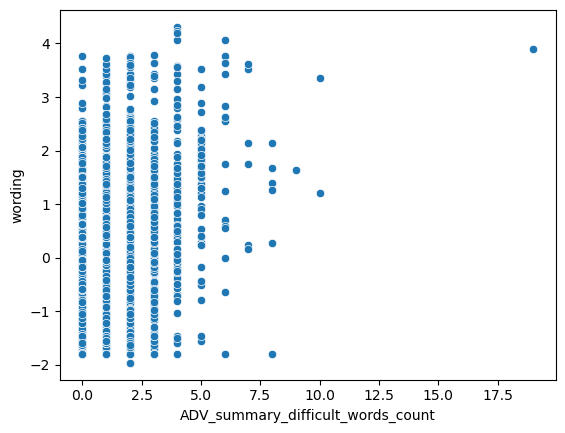

In [37]:
import seaborn as sns

sns.scatterplot(summaries_difficult_words_stats_df['ADV_summary_difficult_words_count'], full_data['wording'])

## Define sentence types

In [38]:
from nltk import sent_tokenize, word_tokenize, pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/jadonng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jadonng/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [39]:
SUBORDINATING_CONJUNCTIONS = """after
although
as
as if
as long as
as much as
as soon as
as though
because
before
even
even if
even though
if
if only
if when
if then
inasmuch
in order that
just as
lest
now
now since
now that
now when
once
provided
provided that
rather that
since
so that
supposing
than
that
though
till
unless
until
when
whenever
where
whereas
where if
wherever
whether
which
while
who
whoever
why""".split("\n")
COORDINATING_CONJUNCTIONS = ['and', 'but', 'or', 'nor', 'so', 'for', 'yet']

In [40]:
def get_sentence_type(sentence):
    words = word_tokenize(sentence)
    pos_tags = pos_tag(words)
    has_dependent_clause = any(
        word.lower() in SUBORDINATING_CONJUNCTIONS for word, pos in pos_tags)
    has_coordinating_conjunction = any(
        word.lower() in COORDINATING_CONJUNCTIONS for word, pos in pos_tags)
    # if has_dependent_clause and has_coordinating_conjunction:
    #     return "compound-complex"
    if has_dependent_clause:
        return "complex"
    elif has_coordinating_conjunction:
        return "compound"
    else:
        return "simple"


def sentence_types_count(sentences):
    """
    Counts the number of sentences of each type in the text.
    """
    sentence_type_count = {
        "simple": 0,
        "compound": 0,
        "complex": 0,
        # "compound-complex": 0
    }

    for sentence in sentences:
        sentence_type = get_sentence_type(sentence)
        sentence_type_count[sentence_type] += 1
    return sentence_type_count


def get_sentence_type_stats(text):
    sentences = sent_tokenize(text)
    sentence_type_count = sentence_types_count(sentences)
    total_sentences = len(sentences)
    sentence_type_stats = {
        f"{k}_ratio": v/total_sentences for k, v in sentence_type_count.items() if v > 0}
    sentence_type_stats["total_sentences"] = total_sentences
    return sentence_type_stats

In [41]:
sentence_type = full_data['text'].progress_apply(
    lambda x: pd.Series(get_sentence_type_stats(x)))
sentence_type.fillna('0', inplace=True)
sentence_type.columns = ['sentence_type_' +
                         str(col) for col in sentence_type.columns]

100%|██████████| 7165/7165 [00:17<00:00, 412.06it/s]


In [63]:
full_data = pd.concat([full_data, sentence_type], axis=1)

In [48]:
sentence_type.columns

Index(['sentence_type_simple_ratio', 'sentence_type_complex_ratio',
       'sentence_type_total_sentences', 'sentence_type_compound_ratio'],
      dtype='object')

/Users/jadonng/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


TypeError: 'value' must be an instance of str or bytes, not a float

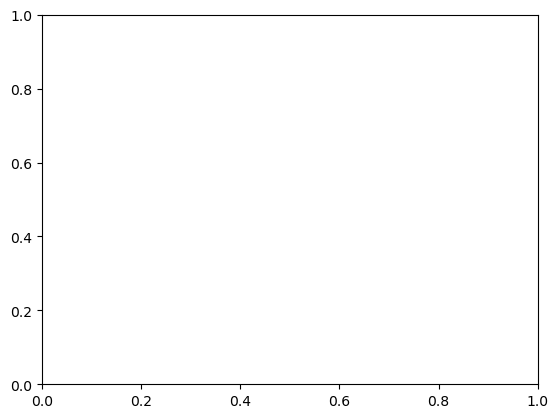

In [51]:

sns.scatterplot(sentence_type['sentence_type_total_sentences'], full_data['wording'])

## Number of **repetitions** in the text

In [64]:
from nltk import ngrams
from nltk.tokenize import word_tokenize
from collections import Counter

In [65]:
def count_repetitions(text, n):
    # Tokenize the original text and summary into words
    summary_tokens = word_tokenize(text)

    summary_ngrams = list(ngrams(summary_tokens, n))
    unique_ngrams = set(summary_ngrams)

    ngrams_count = dict(Counter(summary_ngrams))
    repetitive_ngrams = {k: v for k, v in ngrams_count.items() if v > 1}

    return len(repetitive_ngrams) / len(unique_ngrams)

In [66]:
full_data['bigram_repetitions_in_summary'] = full_data.progress_apply(
    lambda x: count_repetitions(x['text'], 2), axis=1)

100%|██████████| 7165/7165 [00:02<00:00, 3178.85it/s]


In [67]:
full_data['three_gram_repetitions_in_summary'] = full_data.progress_apply(
    lambda x: count_repetitions(x['text'], 3), axis=1)

100%|██████████| 7165/7165 [00:02<00:00, 3271.16it/s]


# Save

In [68]:
full_data.to_csv('full_data.csv', index=False)

In [102]:
from nltk import ngrams


'The third wave was an experimentto see how people reacted to a new one leader government. It gained popularity as people wanted to try new things. The students follow anything that is said and start turning on eachother to gain higher power. They had to stop the experement as too many people got to radical with it blindly following there leader'

In [106]:
Counter(list(ngrams(word_tokenize(full_data['text'][0]),2)))

Counter({('The', 'third'): 1,
         ('third', 'wave'): 1,
         ('wave', 'was'): 1,
         ('was', 'an'): 1,
         ('an', 'experimentto'): 1,
         ('experimentto', 'see'): 1,
         ('see', 'how'): 1,
         ('how', 'people'): 1,
         ('people', 'reacted'): 1,
         ('reacted', 'to'): 1,
         ('to', 'a'): 1,
         ('a', 'new'): 1,
         ('new', 'one'): 1,
         ('one', 'leader'): 1,
         ('leader', 'government'): 1,
         ('government', '.'): 1,
         ('.', 'It'): 1,
         ('It', 'gained'): 1,
         ('gained', 'popularity'): 1,
         ('popularity', 'as'): 1,
         ('as', 'people'): 1,
         ('people', 'wanted'): 1,
         ('wanted', 'to'): 1,
         ('to', 'try'): 1,
         ('try', 'new'): 1,
         ('new', 'things'): 1,
         ('things', '.'): 1,
         ('.', 'The'): 1,
         ('The', 'students'): 1,
         ('students', 'follow'): 1,
         ('follow', 'anything'): 1,
         ('anything', 'that'): 1,
   